### Data exploration

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/noahcampana/Desktop/Studium/Master/Semester 1/Machine Learning/Project/project_data/cleaned_data.csv")

In [3]:
df["readmitted_binary"] = df["readmitted_binary"].astype(int)

In [4]:
df.head()

,encounter_id,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
0,533253,70110,Caucasian,Female,[70-80),No,0,0,2,Emergency,...,3.0,8.0,8,NaN,NaN,False,False,[],0,2
1,426224,29775006,AfricanAmerican,Male,[50-60),No,0,0,0,Emergency,...,16.0,2.0,9,NaN,NaN,False,True,['insulin'],0,0
2,634063,80729253,Caucasian,Female,[60-70),No,0,0,1,Emergency,...,1.0,3.0,6,NaN,NaN,True,True,"['glimepiride', 'insulin']",0,0
3,890610,2919042,AfricanAmerican,Male,[60-70),MC,0,0,1,Emergency,...,9.0,7.0,5,NaN,NaN,False,False,[],0,0
4,654194,84871971,Caucasian,Female,[70-80),HM,1,0,0,Elective,...,10.0,7.0,9,NaN,NaN,False,False,[],0,2


In [5]:
# List of categorical columns
categorical_columns = [
    'race', 'gender', 'age', 'payer_code', 'admission_type',
    'medical_specialty', 'admission_source', 'glucose_test_result',
    'a1c_test_result', 'medication', 'medication_list'
]

# List of numerical columns (excluding IDs and binary flags for medications)
numerical_columns = [
    'average_pulse_bpm', 'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year', 'length_of_stay_in_hospital',
    'non_lab_procedures', 'number_diagnoses', 'number_lab_tests',
    'number_of_medications', 'outpatient_visits_in_previous_year',
    'primary_diagnosis', 'readmitted_multiclass', 'secondary_diagnosis',
    'additional_diagnosis'
]

# List of binary columns (including binary flags for medications)
binary_columns = [
    'discharged_home', 'change_in_meds_during_hospitalization',
    'prescribed_diabetes_meds', 'readmitted_binary',
]


<Axes: >

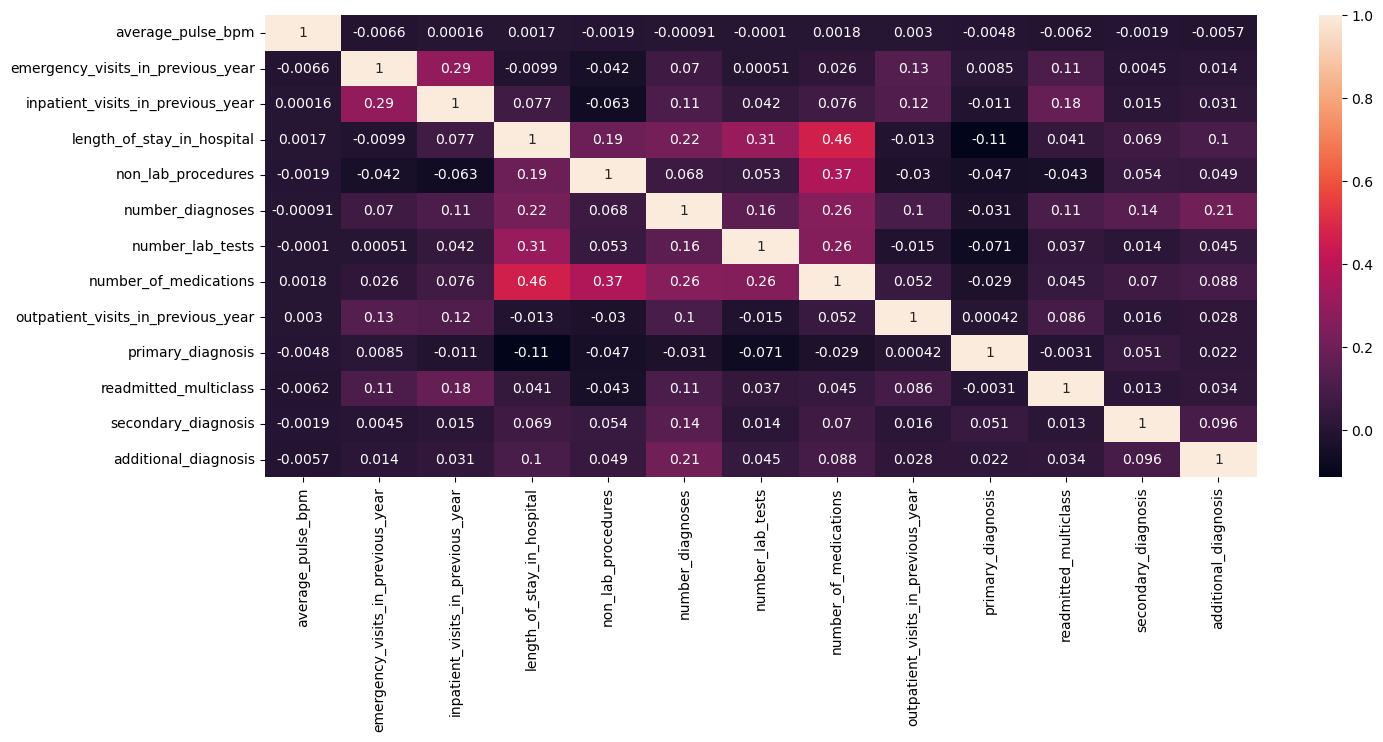

In [6]:
plt.figure(figsize=(16, 6))
sns.heatmap(df[numerical_columns].corr(), annot=True)

In [7]:
# Define the lists for categorical, numerical, and binary columns based on the dataset

# Categorical columns are those with the data type 'object' excluding 'medication' which needs special handling
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('medication')  # 'medication' will be handled separately

# Numerical columns are those with the data type 'int64' or 'float64'
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Binary columns are those with only two unique values
binary_columns = [col for col in df.columns if df[col].nunique() == 2]

# The target variable is 'readmitted_binary', so we'll remove it from the feature lists
if 'readmitted_binary' in numerical_columns: numerical_columns.remove('readmitted_binary')
if 'readmitted_binary' in binary_columns: binary_columns.remove('readmitted_binary')

# Additionally, we should remove identifiers like 'encounter_id' and 'patient_id' from the features
if 'encounter_id' in numerical_columns: numerical_columns.remove('encounter_id')
if 'patient_id' in numerical_columns: numerical_columns.remove('patient_id')

# Now let's display the lists to confirm their contents
categorical_columns, numerical_columns, binary_columns

(['race',
  'gender',
  'age',
  'payer_code',
  'admission_type',
  'medical_specialty',
  'admission_source',
  'glucose_test_result',
  'a1c_test_result'],
 ['outpatient_visits_in_previous_year',
  'emergency_visits_in_previous_year',
  'inpatient_visits_in_previous_year',
  'average_pulse_bpm',
  'length_of_stay_in_hospital',
  'number_lab_tests',
  'non_lab_procedures',
  'number_of_medications',
  'primary_diagnosis',
  'secondary_diagnosis',
  'additional_diagnosis',
  'number_diagnoses',
  'readmitted_multiclass'],
 ['discharged_home',
  'change_in_meds_during_hospitalization',
  'prescribed_diabetes_meds'])

In [9]:
test_data = pd.read_csv("/Users/noahcampana/Desktop/Studium/Master/Semester 1/Machine Learning/Project/project_data/test.csv")
# Preprocessing for numerical data: We will fill missing values with the mean
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data: We will fill missing values with the most frequent value and then do one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Define the Random Forest Classifier model with a reduced number of estimators to save on computation
model = RandomForestClassifier(n_estimators=10, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

# Features and target variable
X = df.drop(['readmitted_binary', 'encounter_id', 'patient_id', 'medication'], axis=1)
y = df['readmitted_binary']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Train the Random Forest Classifier model
clf.fit(X_train, y_train)

# Predict on the testing data
preds = clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, preds)
report = classification_report(y_test, preds)

print(accuracy)
print(report)

0.9853923405891115
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18436
           1       1.00      0.87      0.93      2375

    accuracy                           0.99     20811
   macro avg       0.99      0.94      0.96     20811
weighted avg       0.99      0.99      0.98     20811



In [ ]:
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
#trying naives bayes
data = df.drop(['readmitted_binary', 'encounter_id', 'patient_id', 'medication'], axis=1)
target = df['readmitted_binary']
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.25, stratify = target, random_state=5)


modelNB = GaussianNB(var_smoothing=0.0001)
modelNB.fit(X = X_train, y = y_train)
labels_train = modelNB.predict(X_train)
labels_val = modelNB.predict(X_val)
modelNB.predict_proba(X_val), modelNB.score(X_train, y_train), modelNB.score(X_train, y_train), modelNB.score(X_val, y_val)